In [ ]:
# develop-translation-operator.ipynb
#
# Bryan Daniels
# 2023/9/26
#
# Using the continuous dynamics developed in 'initial-model-brainstorming', create
# a translation operator that can move the edge attractor along the attractor manifold.
#

In [1]:
import simpleNeuralModel
import numpy as np
import scipy.stats
import tqdm
import matplotlib.pyplot as plt
from toolbox import defaultFigure
defaultFigure.setDefaultParams()

In [2]:
def gaussian_kernel_matrix(N,width,normed=True):
    """
    Interaction matrix with Gaussian kernel.
    
    N:       total number of units.  Returned interaction matrix will have shape (N,N)
    width:   width of the Gaussian measured in number of units
    """
    mat = [ scipy.stats.distributions.norm.pdf(range(N),loc=i,scale=width) for i in range(N) ]
    if normed:
        mat = [ row/np.sum(row) for row in mat ]
    return np.array(mat)

In [3]:
class laplace_network:
    
    def __init__(self,N,J=1,kernel_width=2,boundary_input=100,num_inputs=5):
        """
        N              : number of units
        J              : scale of interaction strength among nearby neighbors
        kernel_width   : width of Gaussian kernel for interactions
        boundary_input : field setting boundary conditions (positive on left end and negative on right end)
        num_inputs     : number of fixed input nodes at each end
        """
        self.N = N
        self.J = J
        self.kernel_width = kernel_width
        self.boundary_input = boundary_input
        self.num_inputs = num_inputs
        
        # set interaction matrix
        self.Jmat = J * gaussian_kernel_matrix(N,kernel_width)
        
        # set external inputs
        inputExt = np.zeros(N)
        inputExt[0:num_inputs] = boundary_input
        inputExt[-num_inputs:] = -boundary_input
        self.inputExt = inputExt
        
    def find_edge_state(self,center):
        """
        Find stationary state (fixed point) that looks like an edge at the given location

        center       : desired center location of edge
        """
        # TO DO: should the edge width be equal to the kernel width? (seems to work...)
        width = self.kernel_width
        initialGuessState = -(np.arange(0,N)-center)/width
        initialGuessRates = np.tanh(initialGuessState)
        fp = simpleNeuralModel.findFixedPoint(self.Jmat,initialGuessState,inputExt=self.inputExt)
        return fp
    
    def simulate_dynamics(self,initial_state,t_final,noise_var,additional_input=None,seed=None,delta_t=0.001):
        """
        Use simpleNeuralModel.simpleNeuralDynamics to simulate the network's dynamics.

        additional_input (None)      : If given a list of length N, add this to the existing 
                                         external current as a constant input.
                                       If given an array of shape (# timepoints)x(N), add this
                                         to the existing external current as an input that
                                         varies over time.  (# timepoints = t_final/delta_t)
        seed (None)                  : If given, set random seed before running
        """
        num_timepoints = t_final/delta_t
        if additional_input is not None:
            if np.shape(additional_input) == (N,):
                total_input = self.inputExt + additional_input
            elif np.shape(additional_input) == (num_timepoints,N):
                total_input = [ self.inputExt + a for a in additional_input ]
            else:
                raise Exception("Unrecognized form of additional_input")
        else:
            total_input = self.inputExt
        
        if seed is not None:
            np.random.seed(seed)

        return simpleNeuralModel.simpleNeuralDynamics(self.Jmat,
                                                      total_input,
                                                      noiseVar=noise_var,
                                                      tFinal=t_final,
                                                      initialState=initial_state,
                                                      deltat=delta_t)

In [4]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

N = 50 # number of units
J = 2 # constant interaction strength between neighbors

net = laplace_network(N,J)

In [26]:
# find stationary states (fixed points) that look like an edge
center_list = range(0,N,2)
fp_list = []
for center in center_list:
    fp = net.find_edge_state(center)
    fp_list.append(fp)

In [27]:
# translation input should just be (proportional to) the derivative of edge fixed points
# with respect to position
translation_input_list = np.diff(fp_list,axis=0)

(-2.45, 51.45, -4.0, 4.0)

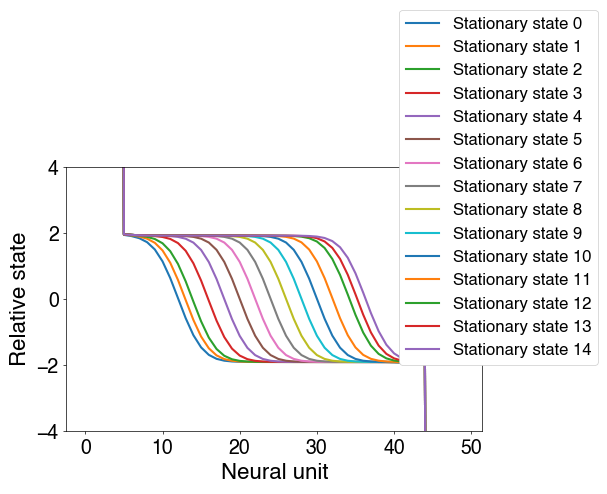

In [28]:
for i,fp in enumerate(fp_list[5:20]):
    plt.plot(fp,label='Stationary state {}'.format(i))
plt.xlabel('Neural unit')
plt.ylabel('Relative state')
leg = plt.legend(loc=(0.8,0.25),framealpha=1)
defaultFigure.makePretty(leg)
plt.subplots_adjust(left=0.15,right=0.8,bottom=0.25,top=0.8)
plt.axis(ymin=-4,ymax=+4)

(-2.45, 51.45, -1.0, 2.0)

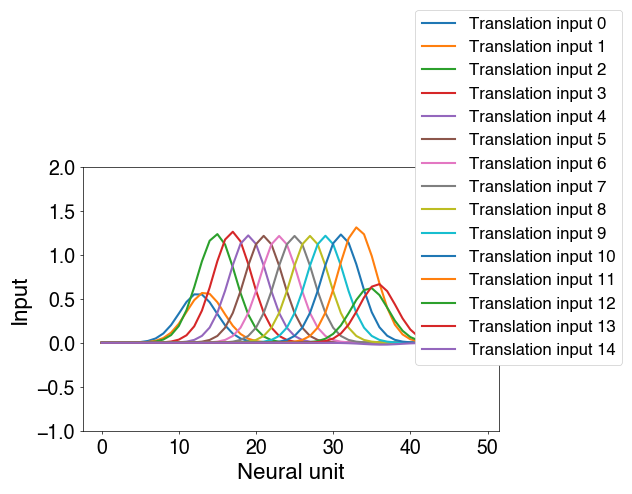

In [36]:
for i,trans_input in enumerate(translation_input_list[5:20]):
    plt.plot(trans_input,label='Translation input {}'.format(i))
plt.xlabel('Neural unit')
plt.ylabel('Input')
leg = plt.legend(loc=(0.8,0.25),framealpha=1)
defaultFigure.makePretty(leg)
plt.subplots_adjust(left=0.15,right=0.8,bottom=0.25,top=0.8)
plt.axis(ymin=-1,ymax=+2)

# are these simply gaussian?
#plt.plot(range(N),6*scipy.stats.distributions.norm.pdf(range(N),loc=25,scale=net.kernel_width),lw=5)

# 2023/9/28 Can we move an edge at constant velocity?

In [94]:
noise_var = 1e-4 # 0.1 # strength of noise (variance added per unit time)
t_final = 50 #100 #20
delta_t = 0.001 #0.001
input_times = np.arange(0,t_final+delta_t,delta_t)[:-1] # don't need an input at the final timepoint
seed = 12345
center = 25

# start at edge state
edge_state = net.find_edge_state(center)

# apply input corresponding to moving delta_n in 1 unit of time
# delta_n = -1 #10 #0.5 # in units of number of neurons
# edge_state_new = net.find_edge_state(center + delta_n)
# translation_input = edge_state_new - edge_state

# apply time-varying input
# goal: move delta_n per unit of time
translation_input_time_varying = []
delta_n = 0.5
edge_state_old = edge_state.copy()
for t in range(t_final):
    # we will only change the input once every time unit
    delta_n_total = delta_n*(t+1)
    edge_state_new = net.find_edge_state(center + delta_n_total)
    translation_input = edge_state_new - edge_state_old
    for t_micro in range(int(1./delta_t)):
        translation_input_time_varying.append(translation_input)
    edge_state_old = edge_state_new.copy()

# simulate dynamics
states = net.simulate_dynamics(edge_state,
                               t_final,
                               noise_var,
                               additional_input=translation_input_time_varying,
                               seed=seed,
                               delta_t=delta_t)
rates = np.tanh(states)

Text(0.5, 0, 'Neural unit')

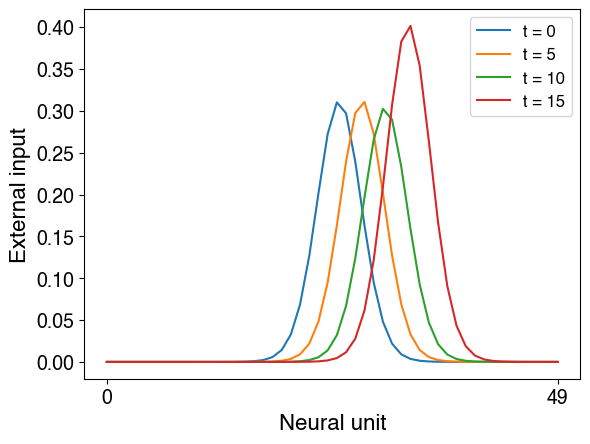

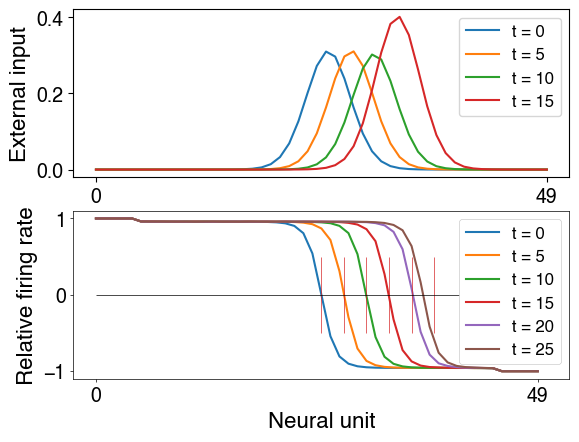

In [119]:
# input plot
plt.subplot(2,1,1)
for t in range(0,20,5):
    plt.plot(translation_input_time_varying[int(t/delta_t)],label='t = {}'.format(t))
plt.legend()
plt.xticks(ticks=[0,N-1],labels=[0,N-1])
plt.ylabel('External input')
plt.xlabel('Neural unit')

# firing rate plot
plt.subplot(2,1,2)
for t in range(0,30,5):
    plt.plot(rates.loc[t],label="t = {}".format(t))
    plt.vlines([center+delta_n*t],-0.5,0.5,color='C3',lw=0.5)
plt.hlines(0,0,50,color='k',lw=0.5)
    
plt.xlabel('Neural unit')
plt.ylabel('Relative firing rate')
leg = plt.legend(framealpha=1)
plt.xticks(ticks=[0,N-1],labels=[0,N-1]);
defaultFigure.makePretty(leg=leg)

plt.savefig('230928_move_edge_constant_velocity.pdf')